Mapping Heat Exposure × Pedestrian Activity in Midtown Manhattan During (Jul-Aug)3-6PM

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
def find_summer_pm_columns(df):
    all_columns = df.columns.tolist()
    summer_pm_columns = []
    for col in all_columns:
        col_lower = col.lower()
        if any(month in col_lower for month in ["june", "july", "august", "summer"]):
            if any(
                pm_ind in col_lower for pm_ind in ["pm", "afternoon", "evening", "late"]
            ):
                summer_pm_columns.append(col)
    if not summer_pm_columns:
        pm_columns = [
            col
            for col in all_columns
            if "pm" in col.lower()
            or "afternoon" in col.lower()
            or "evening" in col.lower()
        ]
        summer_pm_columns = pm_columns
    return summer_pm_columns

In [5]:
def calculate_summer_pm_counts(df, summer_pm_columns):
    if summer_pm_columns:
        numeric_cols = []
        for col in summer_pm_columns:
            try:
                pd.to_numeric(df[col], errors="coerce")
                numeric_cols.append(col)
            except:
                continue
        if numeric_cols:
            df["summer_pm_count"] = df[numeric_cols].mean(axis=1)
        else:
            df["summer_pm_count"] = 0
    else:
        df["summer_pm_count"] = 0
    return df

In [6]:
ped_df = pd.read_csv(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Bi-Annual_Pedestrian_Counts_20250709.csv"
)
temp_df = pd.read_csv(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Hyperlocal_Temperature_Monitoring_20250709.csv"
)
mappluto_gdf = gpd.read_file(
    "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/nyc_mappluto_25v2_shp"
)

In [7]:
manhattan_gdf = mappluto_gdf[mappluto_gdf["Borough"] == "MN"].copy()
manhattan_gdf = manhattan_gdf.to_crs(epsg=4326)

In [8]:
ped_manhattan = ped_df[ped_df["Borough"].str.lower() == "manhattan"].copy()

In [9]:
summer_pm_cols = find_summer_pm_columns(ped_manhattan)
ped_manhattan = calculate_summer_pm_counts(ped_manhattan, summer_pm_cols)

In [10]:
ped_manhattan.columns

Index(['the_geom', 'OBJECTID', 'Loc', 'Borough', 'Street_Nam', 'From_Stree',
       'To_Street', 'Iex', 'May07_AM', 'May07_PM',
       ...
       'Oct23_AM', 'Oct23_PM', 'Oct23_MD', 'June24_AM', 'June24_PM',
       'June24_MD', 'Oct24_AM', 'Oct24_PM', 'Oct24_MD', 'summer_pm_count'],
      dtype='object', length=111)

In [11]:
print(ped_manhattan["the_geom"].head())

34     POINT (-74.01155687409947 40.70463665187375)
35     POINT (-74.01286204592034 40.70634164448271)
36      POINT (-73.98219706247882 40.7718134030119)
37    POINT (-74.01009312926121 40.715904559004244)
38     POINT (-73.97713579908014 40.77968082763136)
Name: the_geom, dtype: object


In [12]:
from shapely import wkt

ped_manhattan["geometry"] = ped_manhattan["the_geom"].apply(wkt.loads)
ped_gdf = gpd.GeoDataFrame(ped_manhattan, geometry="geometry", crs="EPSG:4326")

In [13]:
temp_df.columns

Index(['Sensor.ID', 'AirTemp', 'Day', 'Hour', 'Latitude', 'Longitude', 'Year',
       'Install.Type', 'Borough', 'ntacode'],
      dtype='object')

In [14]:
temp_df["Day"] = pd.to_datetime(temp_df["Day"])
temp_df["Hour"] = temp_df["Day"].dt.hour
heat_window = temp_df[(temp_df["Hour"] >= 15) & (temp_df["Hour"] <= 18)]

avg_temp = (
    heat_window.groupby(["Sensor.ID", "Latitude", "Longitude"])["AirTemp"]
    .mean()
    .reset_index()
)

In [15]:
temp_gdf = gpd.GeoDataFrame(
    avg_temp,
    geometry=gpd.points_from_xy(avg_temp.Longitude, avg_temp.Latitude),
    crs="EPSG:4326",
)

NameError: name 'joined' is not defined

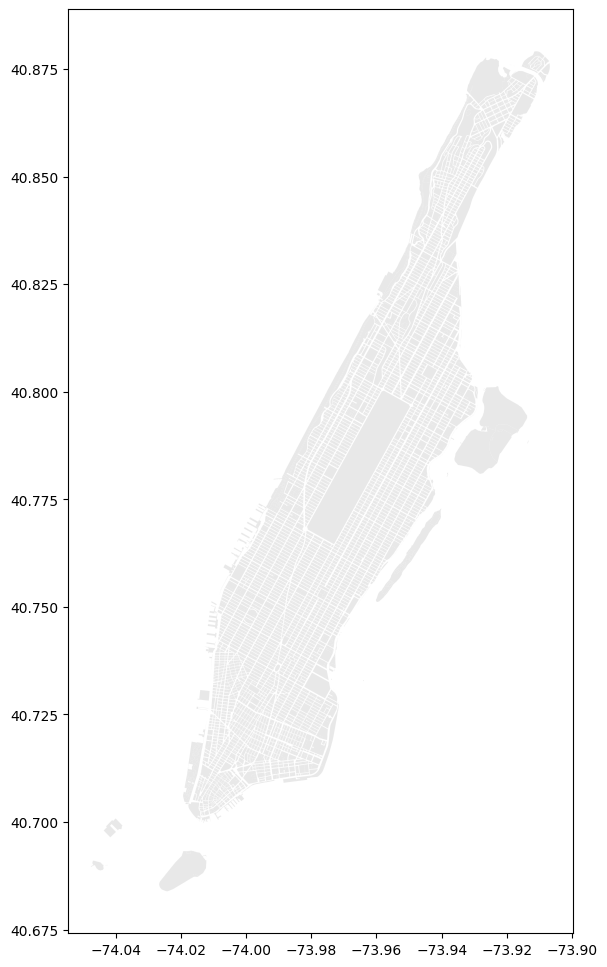

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
manhattan_gdf.plot(ax=ax, color="lightgrey", alpha=0.5)
joined.plot(
    column="Exposure_Index", ax=ax, cmap="Reds", legend=True, markersize=40, alpha=0.7
)
plt.title("Manhattan Heat Exposure × Pedestrian Volume (3-6PM Summer)")
plt.axis("off")
plt.show()